# 3. Sampling the imaginary

In [48]:
%pprint # turn on/off pprint

import os

import arviz as az
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap

import numpyro.distributions as dist

import reth2


if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

Pretty printing has been turned ON


In [64]:
import importlib
importlib.reload(reth2)

<module 'reth2' from '/home/nbooks/stats-rethinking2/reth2.py'>

In [3]:
# Pr(sig|true) = 0.95  - tru-positev rate, power of the test, prob of positive finding when hypotheses are true
# Pr(sig|false) = 0.05 - false-positive rate, prov of positive finding when hypotheses are false
# Pr(true) = 0.01      - base rate at which hypotheses are true. 1 in 100 hypotheses turns out to be true.

In [65]:
p_grid = reth2.grid_gen(1000)

def compute_posterior(N, W):
    prior = reth2.unif_prior(len(p_grid))
    likelihood = reth2.dbinom(p_grid, N, W)
    return reth2.standardize(likelihood * prior)

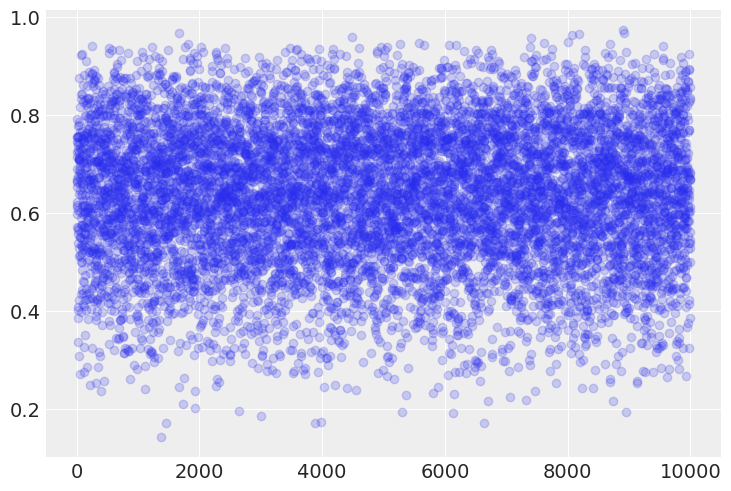

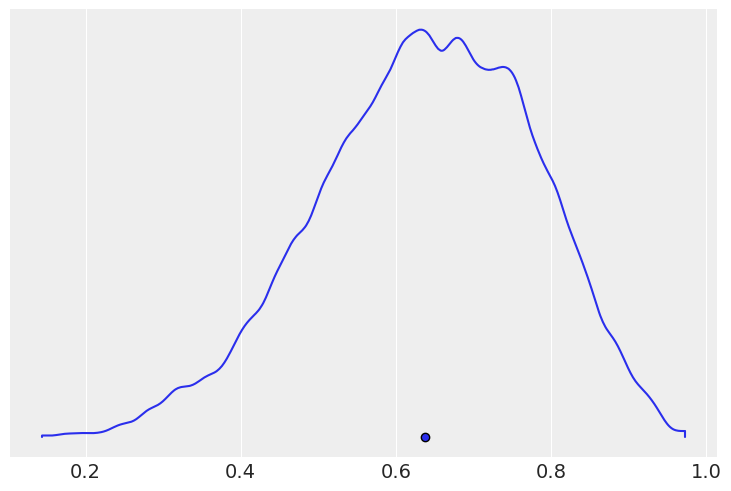

In [66]:
# Code 3.2
posterior = compute_posterior(9, 6)

# Code 3.3
reth2.random_reset(100)
# R: samples <- sample(p_grid, prob=posterior, size=1e4, replace=TRUE)
samples = reth2.samples_grid(p_grid, posterior, 10000)

# Code 3.4
plt.scatter(range(len(samples)), samples, alpha=0.2)
plt.show()

# Code 3.5
az.plot_density({"": samples}, hdi_prob=1)
plt.show()

In [67]:
posterior = compute_posterior(9, 6)
samples = reth2.samples_grid(p_grid, posterior, 10000)

# Code 3.6
# add up posterior probability where p < 0.5
print(jnp.sum(posterior[p_grid < 0.5]))

# Code 3.7, Posterior(p < 0.5)
print(jnp.sum(samples < 0.5) / len(samples))

# Code 3.8, Posterior(0.5 < p < 0.75)
print(jnp.sum((samples > 0.5) & (samples < 0.75)) / len(samples))

0.17187458
0.1665
0.6072


quantile(0.1, 0.9) =[0.451451 0.811812]
percentile(10, 90) =[0.451451 0.811812]


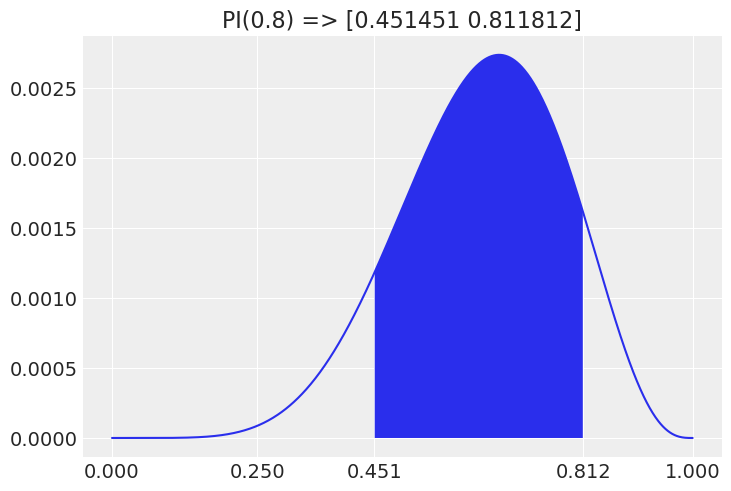

In [68]:
posterior = compute_posterior(9, 6)
samples = reth2.samples_grid(p_grid, posterior, 10000)

# Code 3.9
lo, hi = jnp.quantile(samples, jnp.array([0.1, 0.9]))
print("quantile(0.1, 0.9) =[%f %f]" % (lo, hi))
plt.xticks([0, 0.25, lo, hi, 1])
reth2.fill_interval(p_grid, posterior, (lo, hi), "PI(0.8) => [%f %f]" % (lo, hi))

lo, hi = jnp.percentile(samples, q=jnp.array([10, 90]))
print("percentile(10, 90) =[%f %f]" % (lo, hi))

plt.show()

PI(50) : [0.709710 0.931932]
HDPI(0.500000) : [0.840841 1.000000]
MAP= 1.0
MAP : 0.996997
mean= 0.80163336
median= 0.8408408


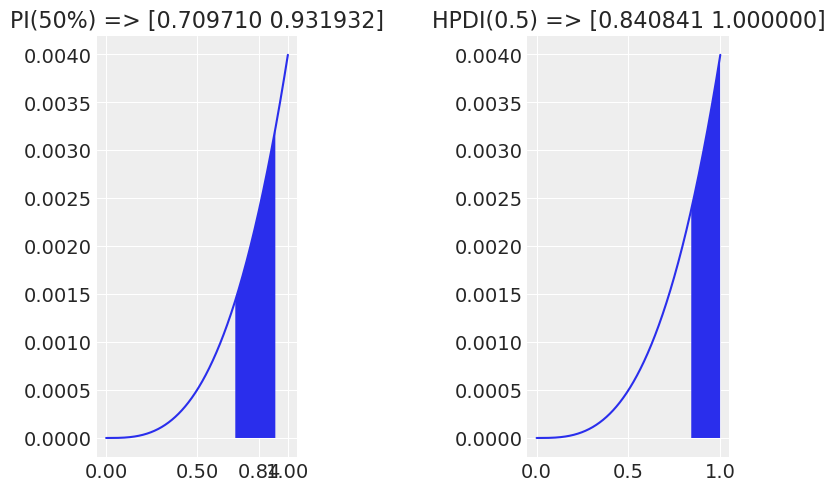

In [69]:
# Code 3.11
posterior = compute_posterior(3, 3)
samples = reth2.samples_grid(p_grid, posterior, 10000)


# Code 3.12, 50% of percentile compatibility interval
# R: PI( samples,prob=0.5), 
lo, hi = reth2.PI(samples, 50)
plt.xticks([0, 0.5, lo, hi])
reth2.fill_interval(p_grid, posterior, (lo, hi), "PI(50%%) => [%f %f]" % (lo, hi), subplot=131)

# Code 3.13, highest posterior density interval
# R: HPDI( samples, prob=0.5 )
lo, hi = reth2.HPDI(samples, 0.5)
plt.xticks([0, 0.5, lo, hi])
reth2.fill_interval(p_grid, posterior, (lo, hi), "HPDI(0.5) => [%f %f]" % (lo, hi), subplot=133)

# Code 3.14, maximum a posteriori
# R: p_grid[ which.max(posterior) ]
print("MAP=", p_grid[jnp.argmax(posterior)])

# Code 3.15
# R: chainmode( samples,adj=0.01)
reth2.MAP(samples)

# Code 3.16
print("mean=", jnp.mean(samples))
print("median=", jnp.median(samples))

plt.show()

In [70]:
# Code 3.17
print("loss(abs) = ", jnp.sum(posterior * jnp.abs(0.5 - p_grid)))

# Code 3.18, list of loss values
# R: loss <- sapply( p_grid, function(d) sum(posterior*abs( d - p_grid ) ) )
loss = vmap(lambda d: jnp.sum(posterior * jnp.abs(d - p_grid)))(p_grid)

# Code 3.19
# R: p_grid[ which.min(loss)]
print("median(loss abs)=", p_grid[jnp.argmin(loss)] )

# Code 3.20
print( reth2.dbinom(0.7, 2, jnp.arange(3)) )


loss(abs) =  0.31287518
median(loss abs)= 0.8408408
[0.09000004 0.42000008 0.49000022]


In [72]:
# Code 3.20
# R: dbinom( 0:2, size=2, prob=0.7 )
print("dbinom=", reth2.dbinom(0.7, 2, jnp.arange(3)))

# Code 3.21
# R: rbinom( 1,size=2,prob=0.7)
print("rbinom (1 toss)", reth2.rbinom(0.7, 2, (1,)))

# Code 3.22
# R: rbinom( 10,size=2,prob=0.7)
print("rbinom (10 toss)", reth2.rbinom(0.7, 2, (10,)))

dbinom= [0.09000004 0.42000008 0.49000022]
rbinom (1 toss) [1]
rbinom (10 toss) [1 1 0 0 1 2 1 0 2 1]


In [73]:
# Code 3.23
dummy_w = reth2.rbinom(0.7, 2, (10000,))
jnp.unique(dummy_w, return_counts=True)[1] / 1e5

DeviceArray([0.00881, 0.0423 , 0.04889], dtype=float32, weak_type=True)

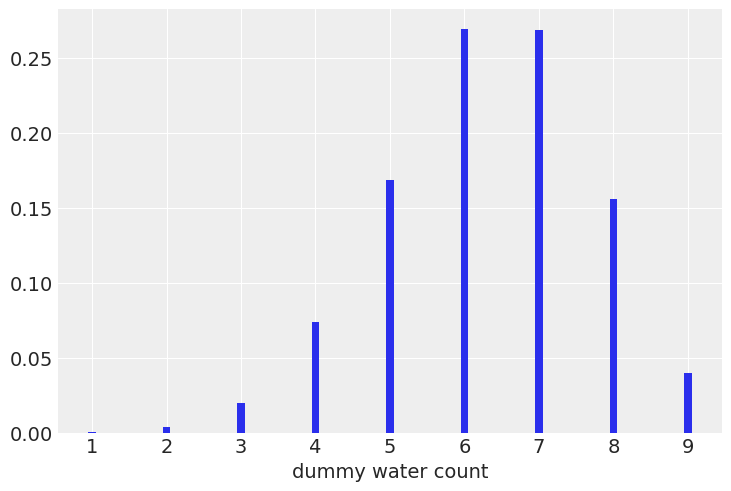

In [75]:
# Code 3.24
dummy_w = reth2.rbinom(0.7, 9, (10000,))
ax = az.plot_dist(dummy_w.copy(), kind="hist", hist_kwargs={"rwidth": 0.1})
ax.set_xlabel("dummy water count", fontsize=14)
plt.show() 

In [76]:
# Code 3.25
# R: w <-rbinom(1e4,size=9,prob=0.6)
w = reth2.r_sample(dist.Binomial(total_count=9, probs=0.6), (int(1e4),))
print(w)

# Code 3.26
# R: w <-rbinom(1e4,size=9,prob=samples)
w = reth2.r_sample(dist.Binomial(total_count=9, probs=samples), (1,))
print(w)

# Code 3.27


[6 6 5 ... 5 6 6]
[[9 8 9 ... 6 8 8]]


# -------------------------------------------------------------
# Practice

In [77]:
p_grid = jnp.linspace(start=0, stop=1, num=1000)
prior = reth2.standardize( jnp.repeat(1, 1000))
likelihood = reth2.dbinom(p_grid, 9, 6)
posterior = reth2.standardize( likelihood * prior )

samples = reth2.samples_grid(p_grid, posterior, 10000)
# 3E1. How much posterior probability lies below p = 0.2?
print("Posterior(p<0.2)    =", jnp.sum(samples<0.2) / len(samples))

# 3E2. How much posterior probability lies above p = 0.8?
print("Posterior(p>0.8)    =", jnp.sum(jnp.sum(samples>0.8) / len(samples)) )

# 3E3. How much posterior probability lies p =[0.2 , 0.8]?
print("Posterior(0.2<p<0.8)=", jnp.sum(jnp.sum((samples > .2) & (samples < .8)) / len(samples)) )

# 3E4. 20% of the posterior probability lies below which value of p?
print("percentile(20)=", jnp.quantile(samples, 0.2))

# 3E5. 20% of the posterior probability lies above which value of p?
print("percentile(80)=", jnp.quantile(samples, 0.8))

# 3E6. Which values of p contain the narrowest interval equal to 66% of the posterior probability?
print("HDPI(0.66)=", reth2.HPDI(samples, 0.66))

# 3E7. Which values of p contain 66% of the posterior probability, assuming equal posterior probability both be low and above the interval?
print("PI(0.66)  =", reth2.PI(samples, 66))

Posterior(p<0.2)    = 0.001
Posterior(p>0.8)    = 0.121
Posterior(0.2<p<0.8)= 0.878
percentile(20)= 0.5185185
percentile(80)= 0.7607607
HDPI(0.660000) : [0.515516 0.784785]
HDPI(0.66)= [0.5155155, 0.7847848]
PI(66) : [0.502332 0.773774]
PI(0.66)  = [DeviceArray(0.50233227, dtype=float32), DeviceArray(0.7737738, dtype=float32)]


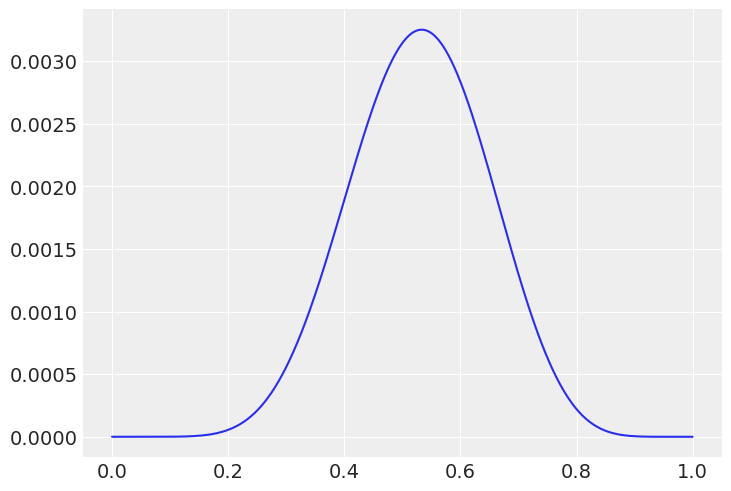

In [78]:
# 3M1. Suppose the globe tossing data had turned out to be 8 water in 15 tosses. 
# Construct theposterior distribution, using grid approximation. Use the same flat prior as before.
p_grid = reth2.grid_gen(1000)
prior = reth2.unif_prior(len(p_grid))
likelihood = reth2.dbinom(p_grid, 15, 8)
posterior = reth2.standardize( likelihood * prior )

samples = reth2.samples_grid(p_grid, posterior, 10000)
plt.plot(p_grid, posterior)

HDPI(0.900000) : [0.333333 0.718719]
HDPI(0.9)= [0.33333334, 0.7187187]
1466.0
1747.0


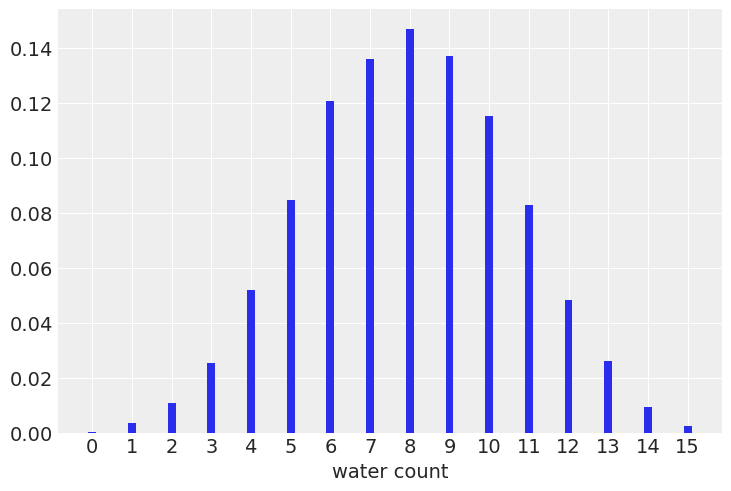

In [81]:
# 3M2
print("HDPI(0.9)=", reth2.HPDI(samples, 0.9))

# 3M3. Construct a posterior predictive check for this model and data.This means simulate the distribution of samples,
#    averaging over the posterior uncertainty in p. What is the probability of observing 8 water in 15 tosses?
# R: w <- rbinom(1e4, size=15, prob=samples)
w = reth2.rbinom(samples, 15, (1,))
print(jnp.sum(w == 8) / len(w) )

ax = az.plot_dist(w.copy(), kind="hist", hist_kwargs={"rwidth": 0.2})
ax.set_xlabel("water count", fontsize=14)

# 3M4.
w = reth2.rbinom(samples, 9, (1,))
print(jnp.sum(w == 6) / len(w) )

plt.show()

HDPI(0.990000) : [0.224224 0.461461]
33 / 100 : 0.237237
HDPI(0.990000) : [0.253253 0.390390]
95 / 300 : 0.137137
HDPI(0.990000) : [0.264264 0.370370]
157 / 500 : 0.106106
HDPI(0.990000) : [0.268268 0.358358]
218 / 700 : 0.090090
HDPI(0.990000) : [0.272272 0.351351]
279 / 900 : 0.079079
HDPI(0.990000) : [0.275275 0.346346]
340 / 1100 : 0.071071
HDPI(0.990000) : [0.275275 0.341341]
401 / 1300 : 0.066066
HDPI(0.990000) : [0.278278 0.339339]
461 / 1500 : 0.061061
HDPI(0.990000) : [0.280280 0.337337]
522 / 1700 : 0.057057
HDPI(0.990000) : [0.280280 0.334334]
583 / 1900 : 0.054054
HDPI(0.990000) : [0.279279 0.331331]
643 / 2100 : 0.052052
HDPI(0.990000) : [0.282282 0.331331]
** 704 / 2300 : 0.049049


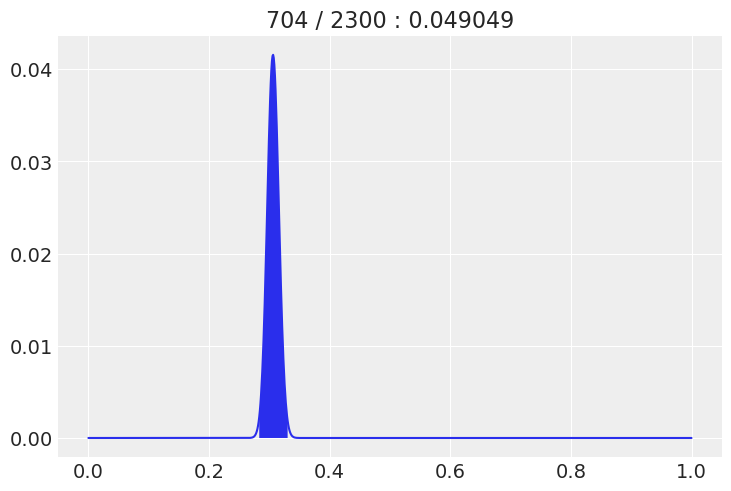

In [82]:
# 3M6 Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. 
# This means the distance between the upper and lower bound of the interval should be 0.05. How many times will you have to toss the globe to do this?

# see https://gregor-mathes.netlify.app/2020/07/31/rethinking-chapter-3/#medium-practices
# This is going to be tricky. We need to simulate sample sizes, and then iteratively apply a function that calculates the 99% percentile interval to these sample sizes. Let’s define the function:
# generate diffrent samples count
reth2.random_reset(100)
p_grid = reth2.grid_gen(1000)
prior = reth2.unif_prior(len(p_grid))

for N in range(100, 3000, 200):
    W =  reth2.rbinom(0.3, N, (1,))[0]

    #posterior = standardize( prior * jnp.exp(dist.Binomial(total_count=N, probs=p_grid).log_prob(W)) )
    # analytical, using Beta
    posterior = reth2.standardize(reth2.dbeta(p_grid, W + 1, (N-W) + 1))
    
    samples = reth2.samples_grid(p_grid, posterior, 10000)
    
    lo, hi = reth2.HPDI(samples, 0.99)
    #lo, hi = jnp.quantile(samples, jnp.array([0.005, 0.995]))
    if abs(hi - lo) < 0.05:
        print ("** %d / %d : %f" % (W, N, hi - lo))
        
        reth2.fill_interval(p_grid, posterior, (lo, hi), "%d / %d : %f" % (W, N, hi - lo))
        plt.show()
        break
    else:
        print ("%d / %d : %f" % (W, N, hi - lo))

boys, girs = [111, 200]
MAP : 0.5545545
MAP : 0.546547
HDPI(0.500000) : [0.533534 0.579580]
HDPI(0.890000) : [0.497497 0.607608]
HDPI(0.970000) : [0.477477 0.629630]


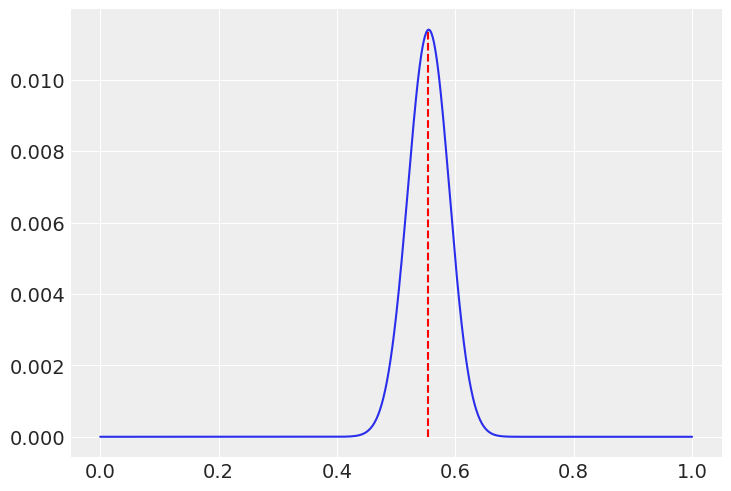

In [83]:
# The Hard problems here all use the data below. These data indicate the gender (male = 1, female = 0) of officially reported first and second born children in 100 two-child families.

birth1 = jnp.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1])
birth2 = jnp.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,1,1,0,0,0,0])

boys, girls = sum(birth1) + sum(birth2), len(birth1) + len(birth2)
print("boys, girs = [%d, %d]" % (boys, girls))

# 3H1 Using grid approximation, compute the posterior distribution for the probability of a birth being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior probability?
p_grid = reth2.grid_gen(1000)
prior = reth2.unif_prior(len(p_grid))

#posterior = reth2.standardize (prior * reth2.PDF(dist.Beta(boys + 1, girls + 1), p_grid))
posterior = reth2.standardize (prior * reth2.dbinom(p_grid, 200, boys))
MAP = p_grid[jnp.argmax(posterior)]
print("MAP :", MAP)
plt.plot(p_grid, posterior)
plt.vlines(MAP, 0, posterior[jnp.where(p_grid==MAP)], colors='r', linestyle='dashed')

# 3H2 Using the sample function,draw 10,000 random parameter values from the posterior distribution you calculated above. Use these samples to estimate the 50%, 89%, and 97% highest posterior density intervals.
samples = p_grid[reth2.r_sample(dist.Categorical(posterior), (10000,))]
reth2.MAP(samples)

reth2.HPDI(samples, 0.5)
reth2.HPDI(samples, 0.89)
_ = reth2.HPDI(samples, 0.97)

394
MAP : 110.000000
mean:  110.977196


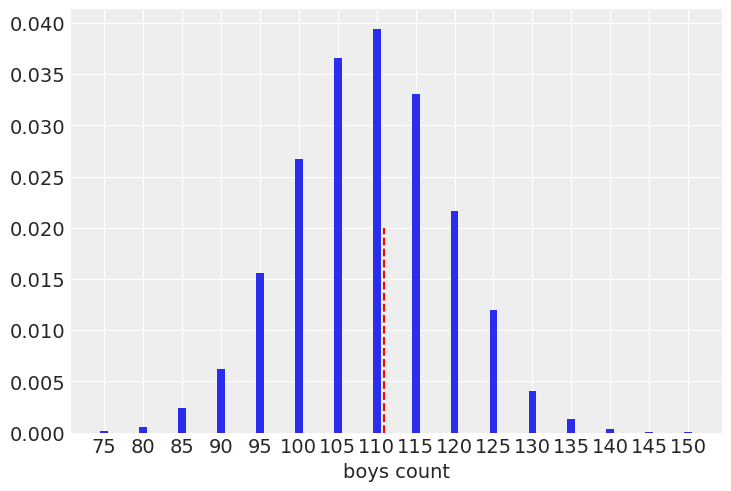

In [104]:
# 3H3 Use rbinom to simulate 222 replicates of 200 births. Yous hould end up with 10,000 numbers, each onea count of boys out of 
#  200 births. Compare the distribution of predicted numbers of boys to the actual count in the data (111 boys out of 200 births).
# There are many good ways to visualize the simulations, but the dens command(part of the rethinking package) is probably the
# easiest way in this case. Does it look like the model fits the data well? That is, does the distribution of predictions 
# include the actual observation as a central, likely o:utcome?
boys_gen = reth2.rbinom(samples, 200, (222,))[1]
print(jnp.sum(boys_gen == 111))

ax = az.plot_dist(boys_gen.copy(), kind="hist", hist_kwargs={"rwidth": 0.2})
ax.set_xlabel("boys count", fontsize=14)
plt.vlines(boys, 0, 0.02, colors='r', linestyle='dashed')

reth2.MAP(boys_gen)
print("mean: ", jnp.mean(boys_gen))


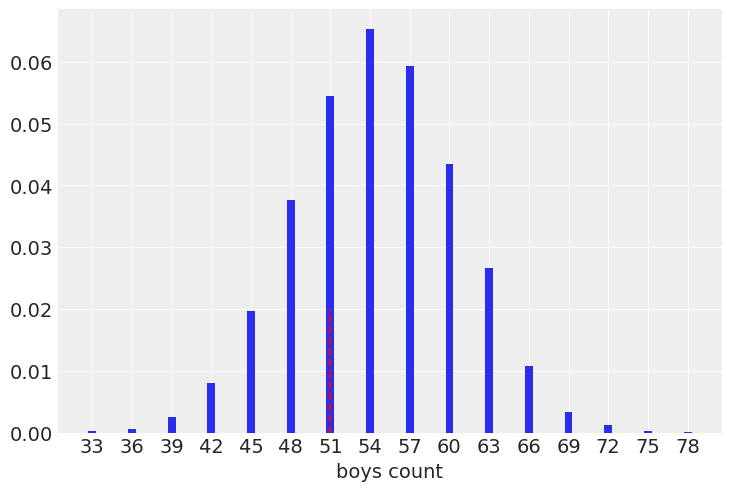

In [105]:
# 3H4. Now compare 222 counts of boys from 100 simulated first borns only to the number of boys
#  in the first births, birth1. How does the model look in this light?
boys1_gen = reth2.rbinom(samples, 100, (222,))[1]

ax = az.plot_dist(boys1_gen.copy(), kind="hist", hist_kwargs={"rwidth": 0.2})
ax.set_xlabel("boys count", fontsize=14)
plt.vlines(jnp.sum(birth1), 0, 0.02, colors='r', linestyle='dashed')

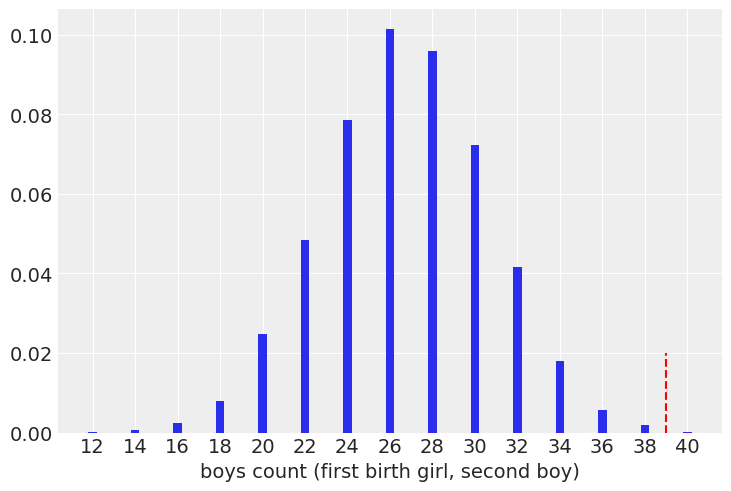

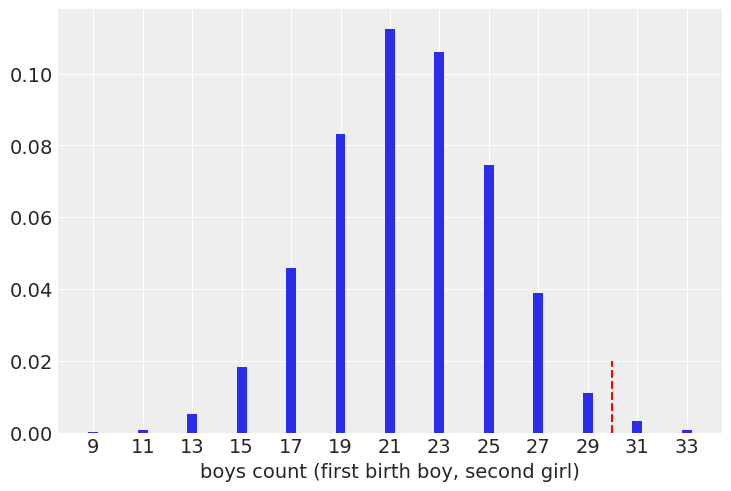

In [111]:
# 3H5
# second boy after first girl
boys2_after_girls1 = birth2[birth1==0]
boys2_after_girls1_gen = reth2.rbinom(samples, len(boys2_after_girls1), (222,))[1]

ax = az.plot_dist(boys2_after_girls1_gen.copy(), kind="hist", hist_kwargs={"rwidth": 0.2})
ax.set_xlabel("boys count (first birth girl, second boy)", fontsize=14)
plt.vlines(jnp.sum(boys2_after_girls1), 0, 0.02, colors='r', linestyle='dashed')
plt.show()

# first boy before second girl
boys1_before_girls2 = birth1[birth2==0]
boys1_before_girls2_gen = reth2.rbinom(samples, len(boys1_before_girls2), (222,))[1]

ax = az.plot_dist(boys1_before_girls2_gen.copy(), kind="hist", hist_kwargs={"rwidth": 0.2})
ax.set_xlabel("boys count (first birth boy, second girl)", fontsize=14)
plt.vlines(jnp.sum(boys1_before_girls2), 0, 0.02, colors='r', linestyle='dashed')
plt.show()